# Hierarchical Agent Teams

We can also create a supervisor agent to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors as shown.

Let us do the following:

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.



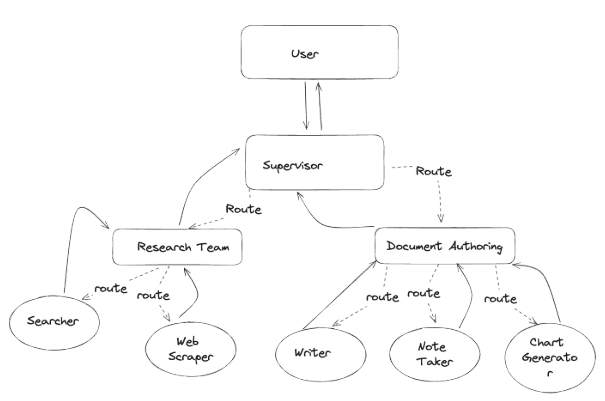

## Setup

First, let's install our required packages and set our API keys

In [1]:
!pip install -U langgraph langchain_community langchain_openai langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 767.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfu

In [2]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your OPENAI_API_KEY··········
Please provide your TAVILY_API_KEY··········


## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.



###ResearchTeam tools

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [3]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5) # https://mcp.tavily.com/mcp/?tavilyApiKey=<your-api-key>

@tool
def scrape_webpages(urls: List[str]) -> str:
  """Use requests and bs4 to scrape the provided web pages for detailed information."""
  loader = WebBaseLoader(urls)
  docs = loader.load()
  return "\n\n".join(
      [
          f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
          for doc in docs
      ]
  )

/tmp/ipython-input-4083967876.py:7: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


###Document writing team tools

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [4]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [5]:
!echo $_TEMP_DIRECTORY

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `echo <TemporaryDirectory '/tmp/tmphmafbq3o'>'


In [6]:
!ls /tmp/tmphmafbq3o

In [ ]:
!cat /tmp/tmpjqz8vni9/Poem_About_Cats.txt

cat: /tmp/tmpjqz8vni9/Poem_About_Cats.txt: No such file or directory


## Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [8]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

class State(MessagesState):
    next: str

def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"



### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [9]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

In [10]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

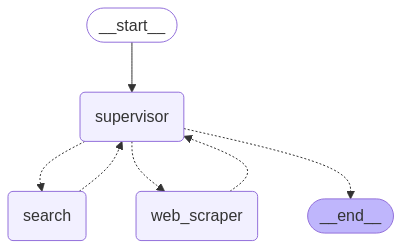

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [ ]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift is currently on "The Eras Tour." It began on March 17, 2023, in Glendale, Arizona, and will conclude on December 8, 2024, in Vancouver, British Columbia, Canada. The tour includes over 50 dates in the United States, along with a series of international dates starting in February 2024 across various countries, including Japan, Australia, Singapore, and several European nations.', additional_kwargs={}, response_metadata={}, name='search', id='9b88f8c8-5000-4867-a2f7-46bf528d1df2')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [11]:
for s in research_graph.stream(
    {"messages": [("user", "Get the full details about Mahatma Gandhi from Wikipedia")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='You can find detailed information about Mahatma Gandhi on his Wikipedia page [here](https://en.wikipedia.org/wiki/Mahatma_Gandhi). Here is a brief summary of the page:\n\n- **Full Name**: Mohandas Karamchand Gandhi\n- **Born**: 2 October 1869 in Porbandar, Kathiawar Agency, India\n- **Died**: 30 January 1948 in New Delhi, India\n- **Occupation**: Lawyer, anti-colonial activist, political ethicist\n- **Known For**: Leading nonviolent resistance to fight for India\'s independence from British rule\n- **Movements Inspired**: Civil rights and freedom movements globally\n- **Honorific Title**: Mahatma (meaning "great-souled" in Sanskrit)\n- **Other Names**: Bāpū (father), Rāṣṭrapitā (Father of the Nation)\n- **Key Campaigns**: Salt March, Quit India Movement, Noncooperation movement\n- **Education**: Samaldas Arts College, University College London, Inns of Court School of Law\n- **Assassination**: He was 

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [12]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)

def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)

def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

With the objects themselves created, we can form the graph.

In [13]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

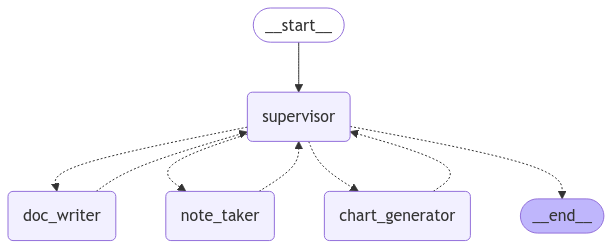

In [ ]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [14]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='I\'ve created and saved the outline for the poem about cats in "poem_outline.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='4e287c56-6c12-45fc-88dc-2c1af74f09c6')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='I have written and saved the poem about cats to "poem_about_cats.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='2c4fc860-e8d9-42e8-b1d0-5c658018d503')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [15]:
!echo $_TEMP_DIRECTORY

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `echo <TemporaryDirectory '/tmp/tmphmafbq3o'>'


In [16]:
!ls /tmp/tmphmafbq3o

poem_about_cats.txt  poem_outline.txt


In [18]:
!cat /tmp/tmphmafbq3o/poem_outline.txt

Title: Whiskers and Paws

Outline:

1. Introduction
   - Description of a cat's mysterious aura
   - The enigmatic eyes that glow in the dark

2. Playful Antics
   - Cats' playful nature
   - Their curious exploration of the world

3. Night Adventures
   - Cats' nocturnal shenanigans
   - Graceful movements in the moonlight

4. Companionship
   - The bond between cats and humans
   - Warmth and comfort in their purrs

5. Conclusion
   - The timeless charm of cats
   - A reminder of the joy they bring to life
   - An ode to the world of whiskers and paws

In [17]:
!cat /tmp/tmphmafbq3o/poem_about_cats.txt

Title: Whiskers and Paws

In moonlit nights, they softly tread,
With mystic grace, they lift their head.
Enchanted eyes like stars that gleam,
Within their gaze, a secret dream.

In daylight's warmth, they skip and play,
In fields of sun, they chase the day.
With playful pounce on unseen foes,
In curious dance, their spirit flows.

When night descends, the world their stage,
In shadows deep, they roam and engage.
Silent whispers, their padded feet,
The moon their guide, in night, they meet.

Yet in our homes, their presence warm,
A gentle purr, a calming storm.
Their silken fur, our hands caress,
In companionship, we find our rest.

Oh, timeless charm of whiskers fine,
In every heart, their lives entwine.
A joy they bring, a gentle pause,
An ode to life with whiskers and paws.

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [19]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [20]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )

def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )

# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

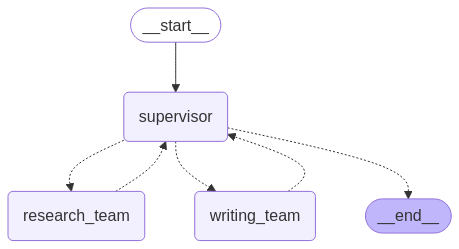

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [21]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="Here's a brief report on AI agents, encapsulating their core components, applications, industry impact, and future outlook:\n\n**Introduction**\nAI agents are sophisticated programs designed to autonomously execute tasks, make informed decisions, and learn through interactions with their environments. They are pivotal in transforming various industries by optimizing efficiency and automating intricate processes.\n\n**Core Components of AI Agents**\n- **Perception**: AI agents leverage sensors and data inputs to interpret their surroundings, enabling effective information gathering for task execution.\n- **Memory**: These agents utilize stored experiences from past interactions to enhance decision-making and performance over time.\n- **Learning**: Employing techniques such as deep learning, AI agents refine their operations by learning from extensive datasets, which continuously enhances 

In [25]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="**AI Agents: A Brief Report**\n\nAI agents are rapidly gaining traction due to their ability to autonomously accomplish complex tasks across various domains. This 2023 overview highlights their growth, technological progress, applications, and future directions.\n\n### Growth and Investment\nIn 2023, AI agents attracted substantial investment, with funding reaching $1.3 billion. This reflects a broader surge in AI technologies capturing 35.7% of global VC deal value, showcasing confidence in their capabilities and potential across diverse sectors.\n\n### Technological Developments\nSignificant advancements include:\n- **Lifelong Learning and Decentralized Collaboration**: These foster resilient AI systems, supporting scalable AI deployments. Reinforcement learning is now integral in facilitating complex cooperation in multi-agent environments.\n- **Privacy and Security in Multi-Agent Sys

In [26]:
!echo $_TEMP_DIRECTORY

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `echo <TemporaryDirectory '/tmp/tmphmafbq3o'>'


In [27]:
!ls /tmp/tmphmafbq3o

AI_Agents_A_Brief_Report.txt	    Outline_of_AI_Agents_A_Brief_Report.txt
AI_Agents_Brief_Report_2023.txt     poem_about_cats.txt
AI_Agents_Brief_Report_Outline.txt  poem_outline.txt
AI_agents_report_outline.txt


In [28]:
!cat /tmp/tmphmafbq3o/AI_Agents_A_Brief_Report.txt

Introduction: AI agents are rapidly gaining traction due to their ability to autonomously accomplish complex tasks across various domains. This 2023 overview highlights their growth, technological progress, applications, and future directions.

Growth and Investment: In 2023, AI agents attracted substantial investment, with funding reaching $1.3 billion. This reflects a broader surge in AI technologies, capturing 35.7% of global VC deal value, showcasing confidence in their capabilities and potential across diverse sectors.

Technological Developments: Significant advancements include:
- Lifelong Learning and Decentralized Collaboration: These foster resilient AI systems, supporting scalable AI deployments. Reinforcement learning is now integral in facilitating complex cooperation in multi-agent environments.
- Privacy and Security in Multi-Agent Systems: Ensuring data security, especially in sensitive sectors, remains critical. Trusted AI frameworks are being developed to enable secur